In [1]:
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torchvision.datasets as datasets


Bad key "text.kerning_factor" on line 4 in
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# let’s initialize the CIFAR train and test set.
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

HBox(children=(FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
train_batch_size = 4
test_batch_size = 4

In [5]:
train_loader = torch.utils.data.DataLoader(
                 dataset=cifar_trainset,
                 batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=cifar_testset,
                batch_size=test_batch_size, shuffle=False)

In [6]:
dataiter = iter(train_loader)
X_batch, y_batch = dataiter.next()

print(X_batch.shape)
print(y_batch.shape)
len(train_loader.dataset), len(test_loader.dataset)

torch.Size([4, 3, 32, 32])
torch.Size([4])


(50000, 10000)

  f r o g


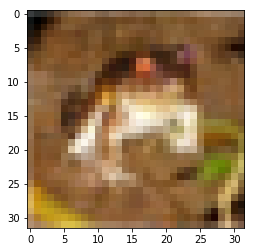


t r u c k


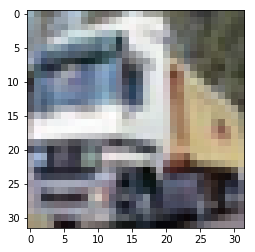

t r u c k


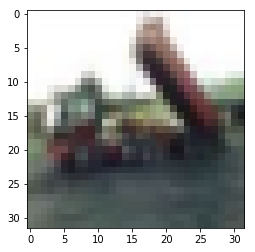

  d e e r


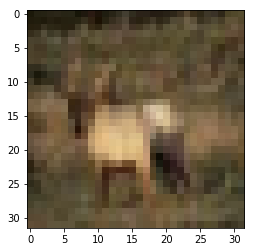

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Showing random images from the batch
def imshow(img):
    for i in range(train_batch_size):
        img[i] = img[i] / 2 + 0.5     # unnormalize
        plt.imshow(img[i].numpy().transpose(1, 2, 0))
        print(' '.join('%5s' % classes[y_batch[i]]))
        plt.show()
          
imshow(X_batch)

In [8]:
train_batch_size = 5000
test_batch_size = 1000

In [9]:
train_loader = torch.utils.data.DataLoader(
                 dataset=cifar_trainset,
                 batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=cifar_testset,
                batch_size=test_batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
#VGG-8
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=(1, 1))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=(1, 1))
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=(1, 1))
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=(1, 1))
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=(1, 1))
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.maxpool(F.relu(self.conv6(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1) 
        return x

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [11]:
def evaluate(model, test_loader):
#model = cnn

    correct = 0 
    model.eval()
    
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        
        # wrapping tensors in variables,  If x is a Variable then x.data is a Tensor giving its value, 
        # and x.grad is another Variable holding the gradient of x with respect to some scalar value
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        
        # output of the model
        output = model.forward(var_X_batch)
                        
        # Calculating the loss 
        # cross entropy function
        error = nn.CrossEntropyLoss()
        loss = error(output, var_y_batch)
            
        predicted = torch.max(output,1)[1]
        
        correct += (predicted == var_y_batch).sum()
        test_accuracy = float(correct*100) / (len(test_loader)*test_batch_size)
    
        test_cost = loss.data
        
    return test_accuracy, test_cost

In [12]:
def fit(model, train_loader, test_loader, epochs, optimizer, loss):
    
    model.train()
    
    import neptune
    
    neptune.init(project_qualified_name='sanghvirajit/sandbox',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiN2Y4MzU5YTctZmJjZS00MmU5LTg4YmYtNDUwZWI5ZTQ3ZmJmIn0=',
             )
    
    # Define parameters
    PARAMS = {'train_batch_size': 5000,
             'test_batch_size': 1000,
             'optimizer': 'Adam'}

    # Create experiment
    neptune.create_experiment('Pytorch-Neptune-CIFAR10-Early Stopping',params=PARAMS,tags=['classification', 'pytorch', 'neptune'])
    
    if optimizer == 'Adam': 
        # Adam optimizer
        optimizer = torch.optim.Adam(model.parameters()) # lr=0.001, betas=(0.9,0.999))
    
    if loss == 'CrossEntropy':
        # cross entropy function
        error = nn.CrossEntropyLoss()
        
    for epoch in range(epochs):
                
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            
            # wrapping tensors in variables,  If x is a Variable then x.data is a Tensor giving its value, 
            # and x.grad is another Variable holding the gradient of x with respect to some scalar value
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
                        
            # we need to set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()
            
            # output of the model
            output = model.forward(var_X_batch)
                        
            # Calculating the loss 
            loss = error(output, var_y_batch)
            train_cost = loss.data
            
            # Let's do backpropogation, it will calculate all the gradients and save to x.grad
            loss.backward()
            
            # Performs a single optimization step,  
            #parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule
            optimizer.step()
            
            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            train_accuracy = float(correct*100) / float(train_batch_size*(batch_idx+1))
            
            #Evaluate
            test_accuracy, test_cost = evaluate(model, test_loader)
                
        print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
            epoch+1, 
            (batch_idx+1)*(len(X_batch)), 
            len(train_loader.dataset), 
            100.*(batch_idx+1) / len(train_loader), 
            train_cost, 
            train_accuracy))
                                                  
        neptune.log_metric('training loss', train_cost)
        neptune.log_metric('training accuracy', train_accuracy)
        
        neptune.log_metric('testing loss', test_cost)
        neptune.log_metric('testing accuracy', test_accuracy)

    # stop experiment
    neptune.stop()

In [ ]:
fit(cnn, train_loader, test_loader, epochs=100, optimizer='Adam', loss='CrossEntropy')

https://ui.neptune.ai/sanghvirajit/sandbox/e/SAN-19
Epoch : 1 [50000/50000 (100%)]	Loss: 2.126764	 Accuracy:16.272%
Epoch : 2 [50000/50000 (100%)]	Loss: 2.178929	 Accuracy:16.854%
Epoch : 3 [50000/50000 (100%)]	Loss: 2.057443	 Accuracy:23.078%
Epoch : 4 [50000/50000 (100%)]	Loss: 1.970724	 Accuracy:27.156%
Epoch : 5 [50000/50000 (100%)]	Loss: 1.878968	 Accuracy:28.786%
Epoch : 6 [50000/50000 (100%)]	Loss: 1.849822	 Accuracy:29.982%
Epoch : 7 [50000/50000 (100%)]	Loss: 1.720235	 Accuracy:34.120%
Epoch : 8 [50000/50000 (100%)]	Loss: 1.622014	 Accuracy:37.438%
Epoch : 9 [50000/50000 (100%)]	Loss: 1.728931	 Accuracy:39.938%
Epoch : 10 [50000/50000 (100%)]	Loss: 1.531176	 Accuracy:41.334%
Epoch : 11 [50000/50000 (100%)]	Loss: 1.475531	 Accuracy:43.390%
Epoch : 12 [50000/50000 (100%)]	Loss: 1.416869	 Accuracy:45.954%
Epoch : 13 [50000/50000 (100%)]	Loss: 1.494866	 Accuracy:45.942%
Epoch : 14 [50000/50000 (100%)]	Loss: 1.378908	 Accuracy:47.256%
Epoch : 15 [50000/50000 (100%)]	Loss: 1.330705	